In [51]:
from math import ceil
from itertools import combinations, product

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy


np.set_printoptions(precision=3, linewidth=200)

In [2]:
# Set seed for reproducibility
np.random.seed(0)

# Create a random collection of interconnected microgrids
N_grids = 5
min_generators_per_grid = 1
max_generators_per_grid = 5

generator_inertia_avg = 10.
generator_inertia_std = 4.
generator_inertia_std_within_grid = 2.

intergrid_susceptance_min = 0.1
intergrid_susceptance_max = 3.0
intragrid_susceptance_avg = 15.0
susceptance_std = 3

generator_damping = 2

# Choose how many generators are in each grid
generators_per_grid = np.random.randint(min_generators_per_grid, max_generators_per_grid, N_grids)

# Choose the average inertia of each grid and the inertia of the generators in each grid
grid_avg_inertias = np.random.normal(loc=generator_inertia_avg, scale=generator_inertia_std, size=(N_grids))
generator_inertias = [
    np.random.normal(loc=avg_inertia, scale=generator_inertia_std_within_grid, size=(n_generators))
    for n_generators, avg_inertia in zip(generators_per_grid, grid_avg_inertias)
]

# Choose the susceptance between grids (we'll only use the upper right triangle of this matrix)
intergrid_susceptance = {
    (i, j): np.random.uniform(intergrid_susceptance_min, intergrid_susceptance_max)
    for i, j in combinations(range(N_grids), 2)
    if i != j
}

# Choose the susceptance between each generator and its grid
generator_susceptance = [
    np.random.normal(loc=intragrid_susceptance_avg, scale=susceptance_std, size=(n_generators))
    for n_generators in generators_per_grid
]

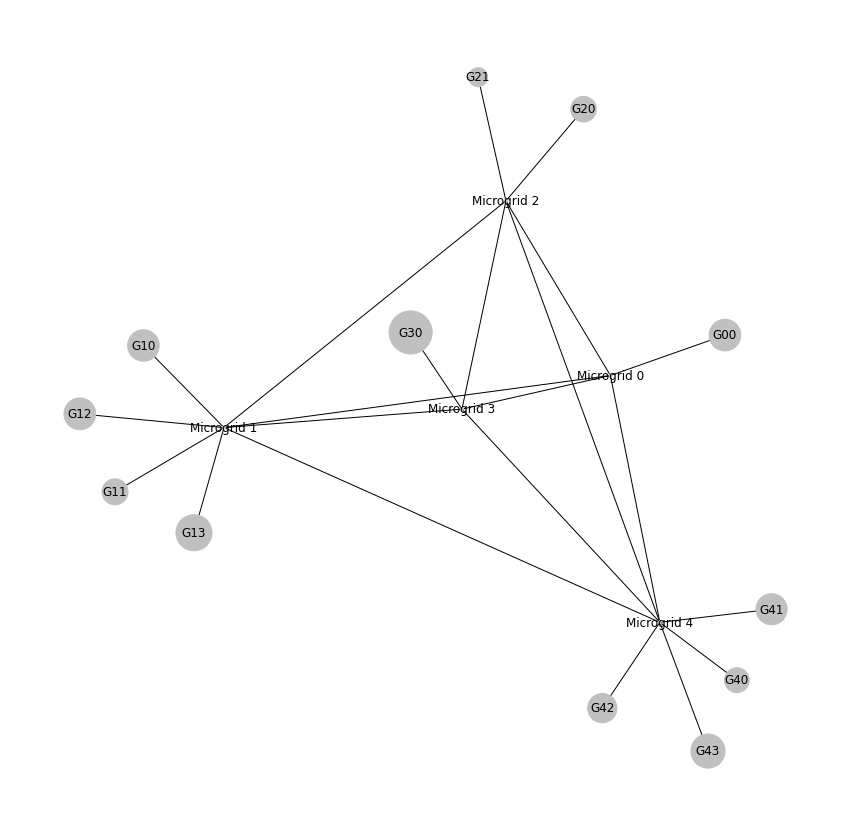

In [246]:
# Visualize the network
G = nx.Graph()

# Add buses for all of the grids
for i in range(N_grids):
    G.add_node(f"Microgrid {i}", inertia=0.1)

# Add edges with the appropriate weight between grids
for connection, susceptance in intergrid_susceptance.items():
    node_a = f"Microgrid {connection[0]}"
    node_b = f"Microgrid {connection[1]}"
    G.add_edge(node_a, node_b, susceptance=susceptance, reactance=1/susceptance)
    
# Add the generators in each grid
for i in range(N_grids):
    grid_name = f"Microgrid {i}"
    for j in range(generators_per_grid[i]):
        node_name = f"G{i}{j}"
        susceptance = generator_susceptance[i][j]
        G.add_node(node_name, inertia=generator_inertias[i][j])
        G.add_edge(node_name, grid_name, susceptance=susceptance, reactance=1/susceptance)
        

# Plot with a spring layout
plt.subplots(figsize=(15, 15))
pos = nx.spring_layout(G, scale=10, seed=0, weight="susceptance")
inertias = [100 * n[1]["inertia"] for n in G.nodes.data()]
nx.draw(G, pos=pos, node_size=inertias, with_labels=True, node_color="silver")

In [4]:
# Get the susceptance matrix by computing the resistance distance between each generator
generator_names = [
    f"G{i}{j}"
    for i in range(N_grids)
    for j in range(generators_per_grid[i])
]
N_G = len(generator_names)
susceptance_matrix = np.zeros((N_G, N_G))
for i, Gi in enumerate(generator_names):
    for j, Gj in enumerate(generator_names):
        # There are two cases. Mutual susceptance is easy, since it's the reciprocal of
        # the reactance distance between two nodes
        if i != j:
            susceptance_matrix[i, j] = 1 / nx.resistance_distance(G, Gi, Gj, weight="reactance")

# The self-susceptance is calculated from the sum of other susceptancs
# TODO: account for loads?
for i in range(N_G):
    susceptance_matrix[i, i] = -susceptance_matrix[i, :].sum()

<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [5]:
# Define inertia and damping matrices
inverse_inertia_matrix = np.diag([1 / G.nodes[generator_name]["inertia"] for generator_name in generator_names])
damping_matrix = np.diag([generator_damping] * N_G)
agc_matrix = np.diag([0.1] * N_G)  # TODO(hack)

# We can now construct the dynamics with states x = [displacement, velocities]^T
A = np.zeros((2 * N_G, 2 * N_G))
A[:N_G, N_G:] = np.eye(N_G)  # derivative of displacement is velocity
A[N_G:, :N_G] = inverse_inertia_matrix @ (susceptance_matrix - agc_matrix)
A[N_G:, N_G:] = -inverse_inertia_matrix @ damping_matrix

if (np.linalg.eigvals(A).real > 0).any():
    print("Dynamics are unstable!")

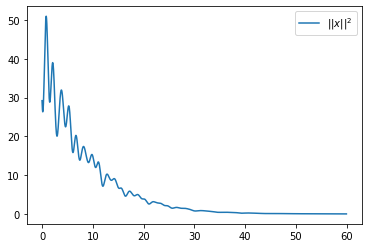

In [212]:
# Now we can simulate the system response from a random initial state
np.random.seed(0)
x0 = np.random.normal(size=(2 * N_G, 1))

T_sim = 60.0
dt = 0.01
xs = np.zeros((2 * N_G, int(T_sim // dt)))
xs[:, 0] = x0.squeeze()

for i in range(1, int(T_sim // dt)):
    xs[:, i] = xs[:, i - 1] + dt * A @ xs[:, i - 1]
    
# Kinetic and potential energy
kinetic_energy = 0.5 * (np.linalg.inv(inverse_inertia_matrix) @ xs[N_G:, :] ** 2).sum(axis=0)
potential_energy = np.zeros(int(T_sim // dt))
for i in range(0, int(T_sim // dt)):
    potential_energy[i] = -0.5 * (xs[N_G:, i].T @ susceptance_matrix @ xs[N_G:, i]).sum(axis=0)
    
t_range = np.arange(0, T_sim - dt, dt)
i = 0  # which generator to plot
# plt.plot(t_range, kinetic_energy + potential_energy, label="Total energy")
plt.plot(t_range, (xs ** 2).sum(axis=0), label="$||x||^2$")
# plt.plot(t_range, potential_energy, label=f"Potential energy")
plt.legend()

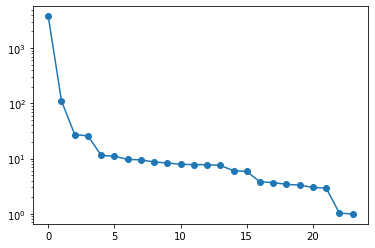

In [323]:
# Now we have an interesting question: what modes of this system contribute most to its behavior?
# Compute the observability grammian with full state observations
C = np.eye(2 * N_G)
Q = scipy.linalg.solve_continuous_lyapunov(A.T, -C.T @ C)
# Compute the controllability grammian with input for velocities
B = np.eye(2 * N_G)
B[:N_G, :N_G] = 0
P = scipy.linalg.solve_continuous_lyapunov(A, -B @ B.T)


# The "energy" released by the system when it starts in state x is x^T Q x, so to get a sense of
# which modes contribute the most energy, we can look at the eigenvalues of Q
w, K = np.linalg.eig(P @ Q)
# Sort w and K descending
idx = w.argsort()[::-1]
w = w[idx]
plt.semilogy(w, "o-")

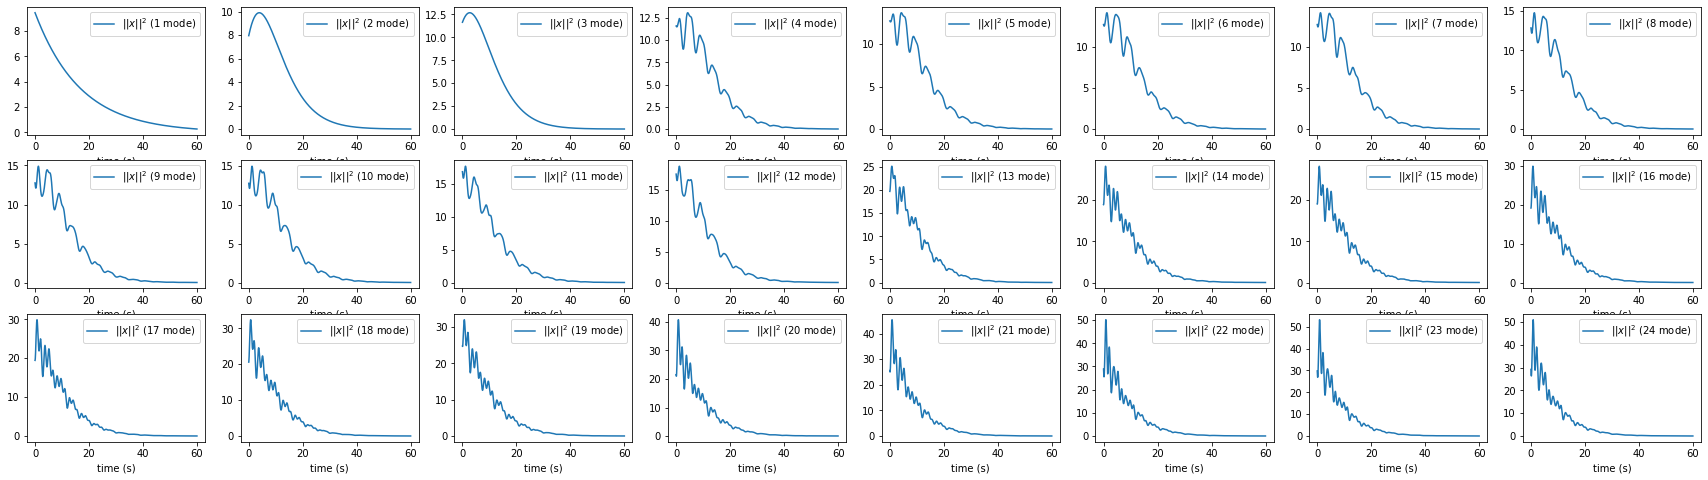

In [333]:
# reduce the order
model_orders = range(1, N_G * 2 + 1)
n_rows = 3
_, axs = plt.subplots(n_rows, ceil(len(model_orders) / n_rows), figsize=(30, 8))
axs = axs.ravel()
energy = np.zeros(N_G * 2)
for ax_idx, n_r in enumerate(model_orders):
    # Balanced transformation
    U = np.linalg.cholesky(P)
    w, K = np.linalg.eig(U.conj().T @ Q @ U)
    # Sort w and K descending
    idx = w.argsort()[::-1]
    w = w[idx]
    K = K[:,idx]
    Sigma = np.diag(np.sqrt(w))
    T = np.sqrt(Sigma) @ K.conj().T @ np.linalg.inv(U)
    Tinv = U @ K @ np.linalg.inv(np.sqrt(Sigma))

    A_r = T @ A @ Tinv

    # reduce the order
    A_r = A_r[:n_r, :n_r]
    T = T[:n_r, :]
    Tinv = Tinv[:, :n_r]

    # Simulate!
    T_sim = 60.0
    dt = 0.01
    xs = np.zeros((n_r, int(T_sim // dt)))
    xs[:, 0] = (T @ x0).squeeze()

    for i in range(1, int(T_sim // dt)):
        xs[:, i] = xs[:, i - 1] + dt * A_r @ xs[:, i - 1]

    # Reconstruct states
    xs = Tinv @ xs

    # Kinetic and potential energy
    kinetic_energy = 0.5 * (np.linalg.inv(inverse_inertia_matrix) @ xs[N_G:, :] ** 2).sum(axis=0)
    potential_energy = np.zeros(int(T_sim // dt))
    for i in range(0, int(T_sim // dt)):
        potential_energy[i] = -0.5 * (xs[N_G:, i].T @ susceptance_matrix @ xs[N_G:, i]).sum(axis=0)

    t_range = np.arange(0, T_sim - dt, dt)
#     axs[ax_idx].plot(t_range, kinetic_energy + potential_energy, label=f"Total energy ({n_r} modes)")
    axs[ax_idx].plot(t_range, (xs ** 2).sum(axis=0), label=f"$||x||^2$ ({n_r} mode)")
#     axs[ax_idx].plot(t_range, potential_energy, label=f"Potential energy")
    axs[ax_idx].legend()
#     axs[ax_idx].set_title(f"{n_r} modes")
    axs[ax_idx].set_xlabel("time (s)")
#     axs[ax_idx].set_ylim([0, 1000])

    energy[n_r - 1] = (xs ** 2).sum() * dt

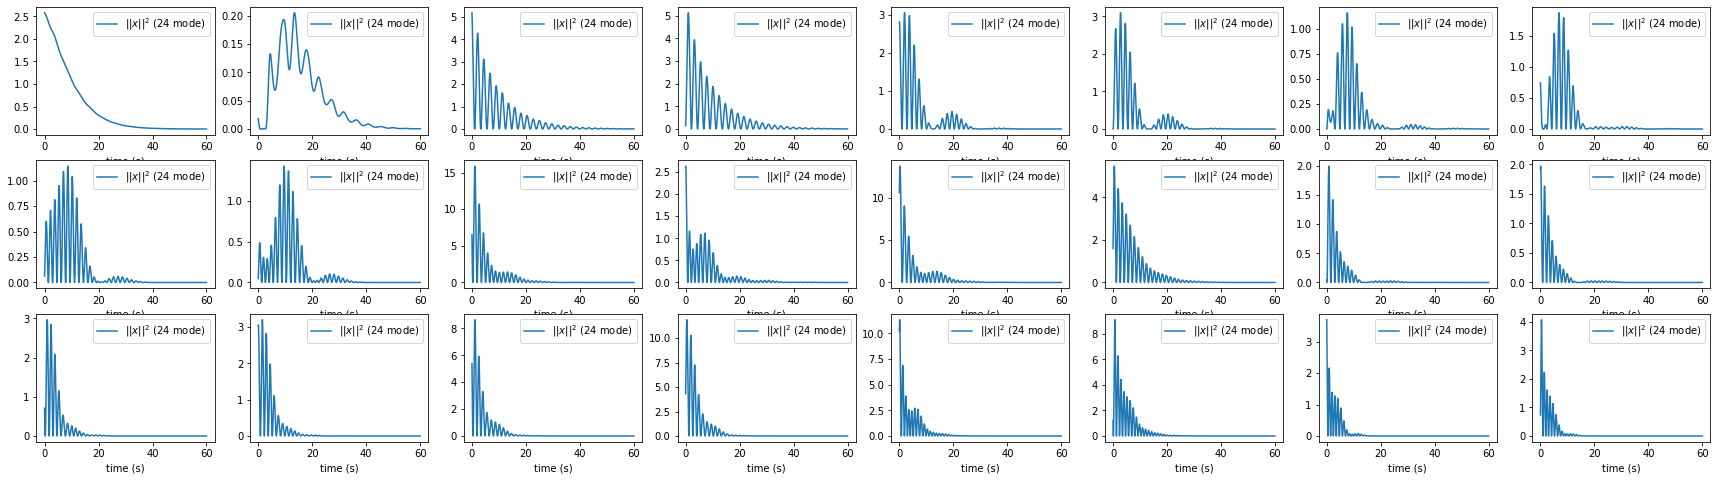

In [340]:
# Balanced transformation
U = np.linalg.cholesky(P)
w, K = np.linalg.eig(U.conj().T @ Q @ U)
# Sort w and K descending
idx = w.argsort()[::-1]
w = w[idx]
K = K[:,idx]
Sigma = np.diag(np.sqrt(w))
T = np.sqrt(Sigma) @ K.conj().T @ np.linalg.inv(U)
Tinv = U @ K @ np.linalg.inv(np.sqrt(Sigma))

x_modes = T @ xs

# Plot by modes
modes = range(0, N_G * 2)
n_rows = 3
_, axs = plt.subplots(n_rows, ceil(len(modes) / n_rows), figsize=(30, 8))
axs = axs.ravel()
energy = np.zeros(N_G * 2)
for ax_idx, mode in enumerate(modes):
    t_range = np.arange(0, T_sim - dt, dt)
    axs[ax_idx].plot(t_range, x_modes[mode, :] ** 2, label=f"$||x||^2$ ({n_r} mode)")
    axs[ax_idx].legend()
    axs[ax_idx].set_xlabel("time (s)")
    energy[mode] = (x_modes[mode, :] ** 2).sum() * dt

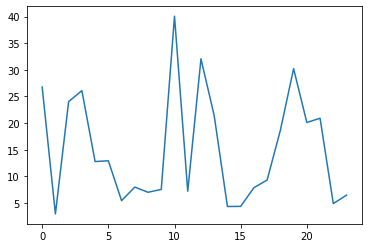

In [344]:
plt.plot(modes, energy)
# plt.ylim([0, 375]);

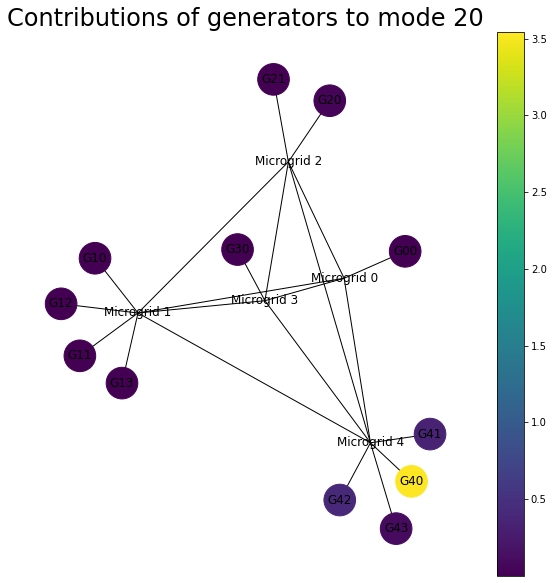

In [275]:
# Now let's visualize the network again to highlight the modes
mode = 20

# Visualize the network
G_viz = nx.Graph()

# Add buses for all of the grids
for i in range(N_grids):
    G_viz.add_node(f"Microgrid {i}", contribution=1e-3)

# Add edges with the appropriate weight between grids
for connection, susceptance in intergrid_susceptance.items():
    node_a = f"Microgrid {connection[0]}"
    node_b = f"Microgrid {connection[1]}"
    G_viz.add_edge(node_a, node_b, susceptance=susceptance, reactance=1/susceptance)
    
# Add the generators in each grid
state_idx = 0
for i in range(N_grids):
    grid_name = f"Microgrid {i}"
    for j in range(generators_per_grid[i]):
        node_name = f"G{i}{j}"
        susceptance = generator_susceptance[i][j]
        G_viz.add_node(node_name, contribution=T[mode, state_idx] ** 2 + T[mode, N_G + state_idx] ** 2)
        G_viz.add_edge(node_name, grid_name, susceptance=susceptance, reactance=1/susceptance)
        state_idx += 1
        

# Plot with a spring layout
plt.subplots(figsize=(10, 10))
pos = nx.spring_layout(G_viz, scale=10, seed=0, weight="susceptance")
contributions = [G_viz.nodes[n]["contribution"] for n in G_viz.nodes]
sizes = [1000 if "Microgrid" not in n else 0 for n in G_viz.nodes]
vmin = min(contributions)
vmax = max(contributions)
nx.draw(G_viz, pos=pos, node_size=sizes, with_labels=True, node_color=contributions, vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)
plt.title(f"Contributions of generators to mode {mode}", fontsize=24);

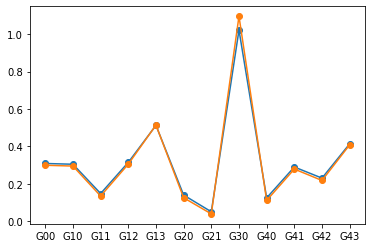

In [285]:
mode = 1
plt.plot(generator_names, (T[:2, :N_G] ** 2 + T[:2, N_G:] ** 2).T, "o-")